In [102]:

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import pathlib

import json

In [86]:
corr_file = pathlib.Path.cwd() / 'results/resnet50/train/2020-01-30-23-31-04/corr.json'
with open(corr_file) as fn:
    corr_dict = json.load(fn)
    
tiny_wnid_file = (pathlib.Path.cwd() / 
                  '../search_download_images/flickr/tiny_classes_to_search.json').resolve()
with open(tiny_wnid_file) as fn:
    tiny_dict = json.load(fn)

In [109]:
acc_dist[acc_sorted_idx]

TypeError: only integer scalar arrays can be converted to a scalar index

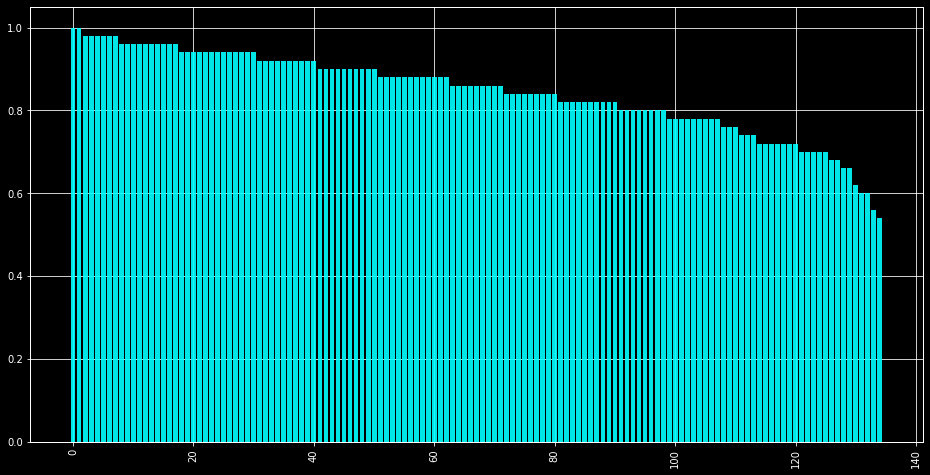

In [116]:
acc_dist = [x/50 for x in corr_dict.values()]
wnid_dist = [k for k in corr_dict.keys()]

acc_sorted_idx = np.argsort(-np.array(acc_dist))

plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
# train_bar = plt.bar(wnid_dist[acc_sorted_idx], acc_dist[acc_sorted_idx], facecolor='aqua', alpha=0.9
train_bar = plt.bar(np.arange(len(acc_sorted_idx)), np.array(acc_dist)[acc_sorted_idx], facecolor='aqua', alpha=0.9)

#### Flickr images error distribution

In [88]:
corr_file_flickr = pathlib.Path.cwd() / 'results/resnet50/candidate/2020-01-31-02-23-50/corr.json'
with open(corr_file_flickr) as fn:
    corr_dict_flickr = json.load(fn)

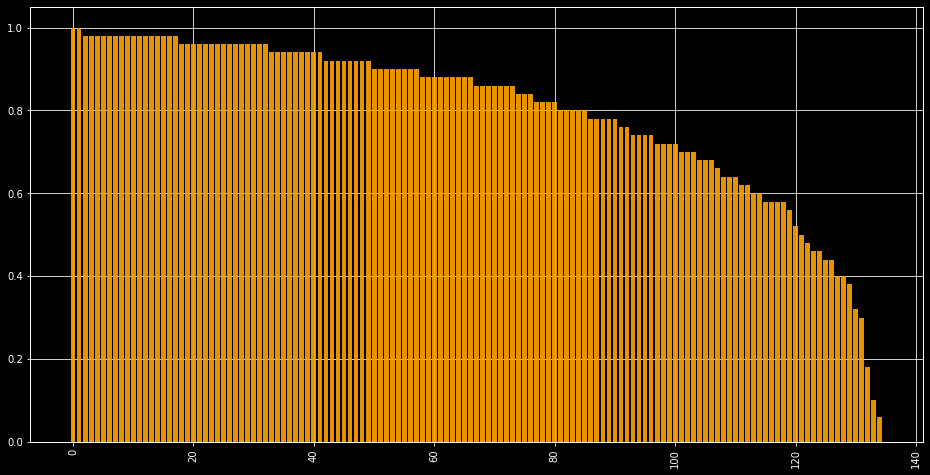

In [118]:
acc_dist_flickr = [corr_dict_flickr[k]/50 for k in wnid_dist]

acc_sorted_idx_flickr = np.argsort(-np.array(acc_dist_flickr))

plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
# train_bar = plt.bar(wnid_dist, acc_dist_flickr, facecolor='orange', alpha=0.9)
train_bar = plt.bar(np.arange(len(acc_sorted_idx_flickr)), np.array(acc_dist_flickr)[acc_sorted_idx_flickr], facecolor='orange', alpha=0.9)

In [182]:
import scipy.stats
def clopper_pearson(k,n,alpha=0.32):
    """
    http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    alpha confidence intervals for a binomial distribution of k expected successes on n trials
    Clopper Pearson intervals are a conservative estimate.
    """
    lo = scipy.stats.beta.ppf(alpha/2, k, n-k+1)
    hi = scipy.stats.beta.ppf(1 - alpha/2, k+1, n-k)
    if str(hi) == 'nan':
        hi = 1
    return lo, hi

In [181]:
clopper_pearson(0.06*50, 50, 0.05)

(0.012548587835334062, 0.1654819466037729)

In [176]:
1/50

0.02

In [183]:
sorted_im_acc = np.array(acc_dist)[acc_sorted_idx]
sorted_fli_acc = np.array(acc_dist_flickr)[acc_sorted_idx_flickr]

im_arr = [(clopper_pearson(int(k*50), 50, 0.05)) for k in sorted_im_acc]
fli_arr = [(clopper_pearson(int(k*50), 50, 0.05)) for k in sorted_fli_acc]

In [184]:
cur_file = pathlib.Path.cwd() / 'results/resnet50/candidate/2020-02-01-00-56-14/error_histogram.txt'

np.savetxt(cur_file,
           np.column_stack((
               sorted_im_acc,
               sorted_fli_acc, 
               np.array([i[0] for i in im_arr]), 
               np.array([i[1] for i in im_arr]), 
               np.array([i[0] for i in fli_arr]), 
               np.array([i[1] for i in fli_arr]))),   # two column format
           header='imagenet flickr im_low im_high fli_low fli_high',
           comments='',
           fmt="%.2f")

In [97]:
sort_idx = np.argsort(np.array([acc_dist_flickr[i]-acc_dist[i] for i in range(len(acc_dist))]))
cand_dir = pathlib.Path.cwd() / 'data/candidate/'
other_cand_dir = pathlib.Path.cwd() / 'data/candidate_other/'

rev_flag = False
cnt = 0
for cur_wnid in [wnid_dist[idx] for idx in sort_idx[::-1]]:
    f_acc = corr_dict_flickr[cur_wnid]/50
    i_acc = corr_dict[cur_wnid]/50
    
    if (not rev_flag) and (f_acc < i_acc):
        rev_flag = True
        print('\n\n')
    
    cnt += 1
    if f_acc < 0.7:
        print('[{}]:\t wnid: {},\t flickr_acc: {:.1f},\t imnet_acc: {:.1f},\t diff: {:.1f},\t num_imgs: {}'
             .format(cnt, cur_wnid, f_acc*100, i_acc*100, (f_acc*100-i_acc*100), len(list( (cand_dir / cur_wnid).iterdir()))))

[66]:	 wnid: n03804744,	 flickr_acc: 62.0,	 imnet_acc: 62.0,	 diff: 0.0,	 num_imgs: 8733



[72]:	 wnid: n02841315,	 flickr_acc: 68.0,	 imnet_acc: 70.0,	 diff: -2.0,	 num_imgs: 3471
[81]:	 wnid: n02906734,	 flickr_acc: 66.0,	 imnet_acc: 68.0,	 diff: -2.0,	 num_imgs: 5971
[86]:	 wnid: n02814533,	 flickr_acc: 68.0,	 imnet_acc: 72.0,	 diff: -4.0,	 num_imgs: 15673


FileNotFoundError: [Errno 2] No such file or directory: '/root/dockspace/imagenet_candidate_training/data/candidate/n02233338'

In [91]:
top100_file = pathlib.Path.cwd() / 'top100_wnid_on_acc_diff.json'

with open(top100_file, 'w') as f:
    json.dump([wnid_dist[idx] for idx in sort_idx[::-1]][:100], f, indent=2)

### Confusion Matrix

In [2]:
num_test = 50          # number of test examples, don't change for ImageNet.

# original
npy_file = pathlib.Path.cwd() / 'results/resnet50/train/2020-02-01-00-02-47/confmat.npy'
npy_file_flickr = pathlib.Path.cwd() / 'results/resnet50/candidate/2020-02-01-00-38-38/confmat.npy'

# for standalone use as an example notebook. Adjust the directory information
# npy_file = pathlib.Path.cwd() / 'confmat.npy'
# npy_file_flickr = pathlib.Path.cwd() / 'confmat_flickr.npy'


conf_mat = np.load(npy_file)
conf_mat = np.stack([conf_mat[i,:] / num_test for i in range(conf_mat.shape[0])])
conf_mat_diag = np.array([conf_mat[i][i] for i in range(conf_mat.shape[0])])
conf_mat_low = np.argwhere(conf_mat_diag < 0.6)

conf_mat_flickr = np.load(npy_file_flickr)
conf_mat_flickr = np.stack([conf_mat_flickr[i,:] / num_test for i in range(conf_mat_flickr.shape[0])])
conf_mat_diag_flickr = np.array([conf_mat_flickr[i][i] for i in range(conf_mat_flickr.shape[0])])
conf_mat_low_flickr = np.argwhere(conf_mat_diag_flickr < 0.6)

In [3]:
cur_cmap = 'pink'
# cur_cmap = 'Blues'
# cur_cmap = 'hot'
# cur_cmap = 'PuBuGn'
# cur_cmap = 'BuPu'

In [ ]:
select_worse = False

cls_selector = (conf_mat_low.flatten() if select_worse else np.arange(conf_mat.shape[0]))

plt.figure(figsize=(16,16))
plt.imshow(conf_mat[cls_selector, ::], 
           interpolation='nearest', cmap=cur_cmap)
plt.show()

In [ ]:
select_worse = False

cls_selector = (conf_mat_low_flickr.flatten() if select_worse 
                else np.arange(conf_mat_flickr.shape[0]))
scatter_idx = (np.arange(len(conf_mat_low_flickr.flatten())) if select_worse
               else np.arange(conf_mat_flickr.shape[0]))

plt.figure(figsize=(16,16))
plt.imshow(conf_mat_flickr[cls_selector, ::], 
           interpolation='nearest', cmap=cur_cmap)

plt.scatter(cls_selector, scatter_idx, marker='*')
plt.show()
# plt.colorbar()

In [ ]:
cur_idx = 125
print(conf_mat_flickr[cur_idx])
print(conf_mat_flickr[cur_idx][cur_idx])

#### Sort by worse performance and record top-5 cross error

In [6]:
# sort the confusion matrix by the rows
sorted_idx = np.argsort(conf_mat_diag_flickr)
conf_mat_sorted_flickr = conf_mat_flickr[sorted_idx, ::]

# load index to class wnid mappings
idx2cls_file = pathlib.Path.cwd() / 'results/resnet50/candidate/2020-02-01-00-56-14/idx2cls.json'
with open(idx2cls_file) as fn:
    idx2cls = json.load(fn)

In [27]:
row_data = []     # this is row based format, not so good for pgfplots
row_data_t = []   # this is the two column format

for cur_idx, cur_row in enumerate(conf_mat_sorted_flickr):
    if cur_row[sorted_idx[cur_idx]] < 1.1:
        cur_list = []
        cur_list.append([idx2cls[str(sorted_idx[cur_idx])], cur_row[sorted_idx[cur_idx]]])
        
        cur_sorted_idx = np.argsort(-cur_row)
        cur_sorted_idx = cur_sorted_idx[cur_sorted_idx != sorted_idx[cur_idx]]
        
        cur_list += [[idx2cls[str(i)], cur_row[i]] for i in cur_sorted_idx]
        row_data.append([i for l in cur_list for i in l])
        row_data_t += cur_list

In [28]:
np.vstack(row_data)[:,1::2].T.shape

(135, 135)

In [30]:
np.vstack(row_data)[:,1::2].T[:,6]

array(['0.4', '0.54', '0.02', '0.02', '0.02', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
       '0.0', '0

In [29]:
conf_bar_file = idx2cls_file.parent / 'conf_bar_plots.txt'

cur_header = 'orig orig_acc'
for i in range(1,6):
    cur_wnid = ' wnid' + str(i)
    cur_header += cur_wnid*2 + '_acc'

np.savetxt(conf_bar_file, 
           # np.vstack(row_data),   # non-pgfplots format
           np.vstack(row_data)[:,1::2].T, # two column format
           # header=cur_header,
#            header='wnid acc',
           comments='',
           fmt="%s")

In [142]:
# np.vstack(row_data)[:,1::2].T.astype(float)[0,:20]
zeroed_conf = np.vstack((np.vstack(row_data)[:,1::2].T.astype(float)[0,:20], np.zeros((9,20))))

In [143]:
zeroed_conf

array([[0.06, 0.1 , 0.18, 0.3 , 0.32, 0.38, 0.4 , 0.4 , 0.44, 0.44, 0.46,
        0.46, 0.48, 0.5 , 0.52, 0.56, 0.58, 0.58, 0.58, 0.58],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0. 

In [140]:
zeroed_conf.shape

(11, 20)

In [144]:
conf_bar_file = idx2cls_file.parent / 'conf_zeroed.txt'

np.savetxt(conf_bar_file, 
           # np.vstack(row_data),   # non-pgfplots format
           zeroed_conf, # two column format
           # header=cur_header,
#            header='wnid acc',
           comments='',
           fmt="%f")

In [ ]:
# Individual files as pgfplots is a pia to use with custom ticklabels otherwise!!!
conf_bar_dir = idx2cls_file.parent / 'conf_plots'
conf_bar_dir.mkdir(exist_ok=True)

for i in range(len(row_data)):
    cur_list = [row_data_t[j] for j in range(i*6, i*6+6)]
    cur_file = conf_bar_dir / ('conf' + str(i).zfill(2) + '.txt')
    
    np.savetxt(cur_file,
               np.vstack(cur_list),   # two column format
               header='wnid acc',
               comments='',
               fmt="%s")

In [ ]:
select_worse = False

cls_selector = (conf_mat_low_flickr.flatten() if select_worse 
                else np.arange(conf_mat_flickr.shape[0]))
scatter_idx = (np.arange(len(conf_mat_low_flickr.flatten())) if select_worse
               else np.arange(conf_mat_flickr.shape[0])[sorted_idx])

plt.figure(figsize=(16,16))
plt.imshow(conf_mat_sorted_flickr[cls_selector, ::], 
           interpolation='nearest', cmap=cur_cmap)

# plt.scatter(cls_selector, scatter_idx, marker='*')
plt.scatter(scatter_idx, cls_selector, marker='*')
plt.show()

#### Get the number of images

In [146]:
cand_dir = pathlib.Path.cwd() / 'data/candidate/'

num_imgs_dict = {}
for cur_wnid in [wnid_dist[idx] for idx in sort_idx[::-1]][:100]:
    num_imgs_dict[cur_wnid] = len(list((cand_dir / cur_wnid).iterdir()))

In [149]:
sum([i for i in num_imgs_dict.values()])

1449437

#### Bar plots for error distribution

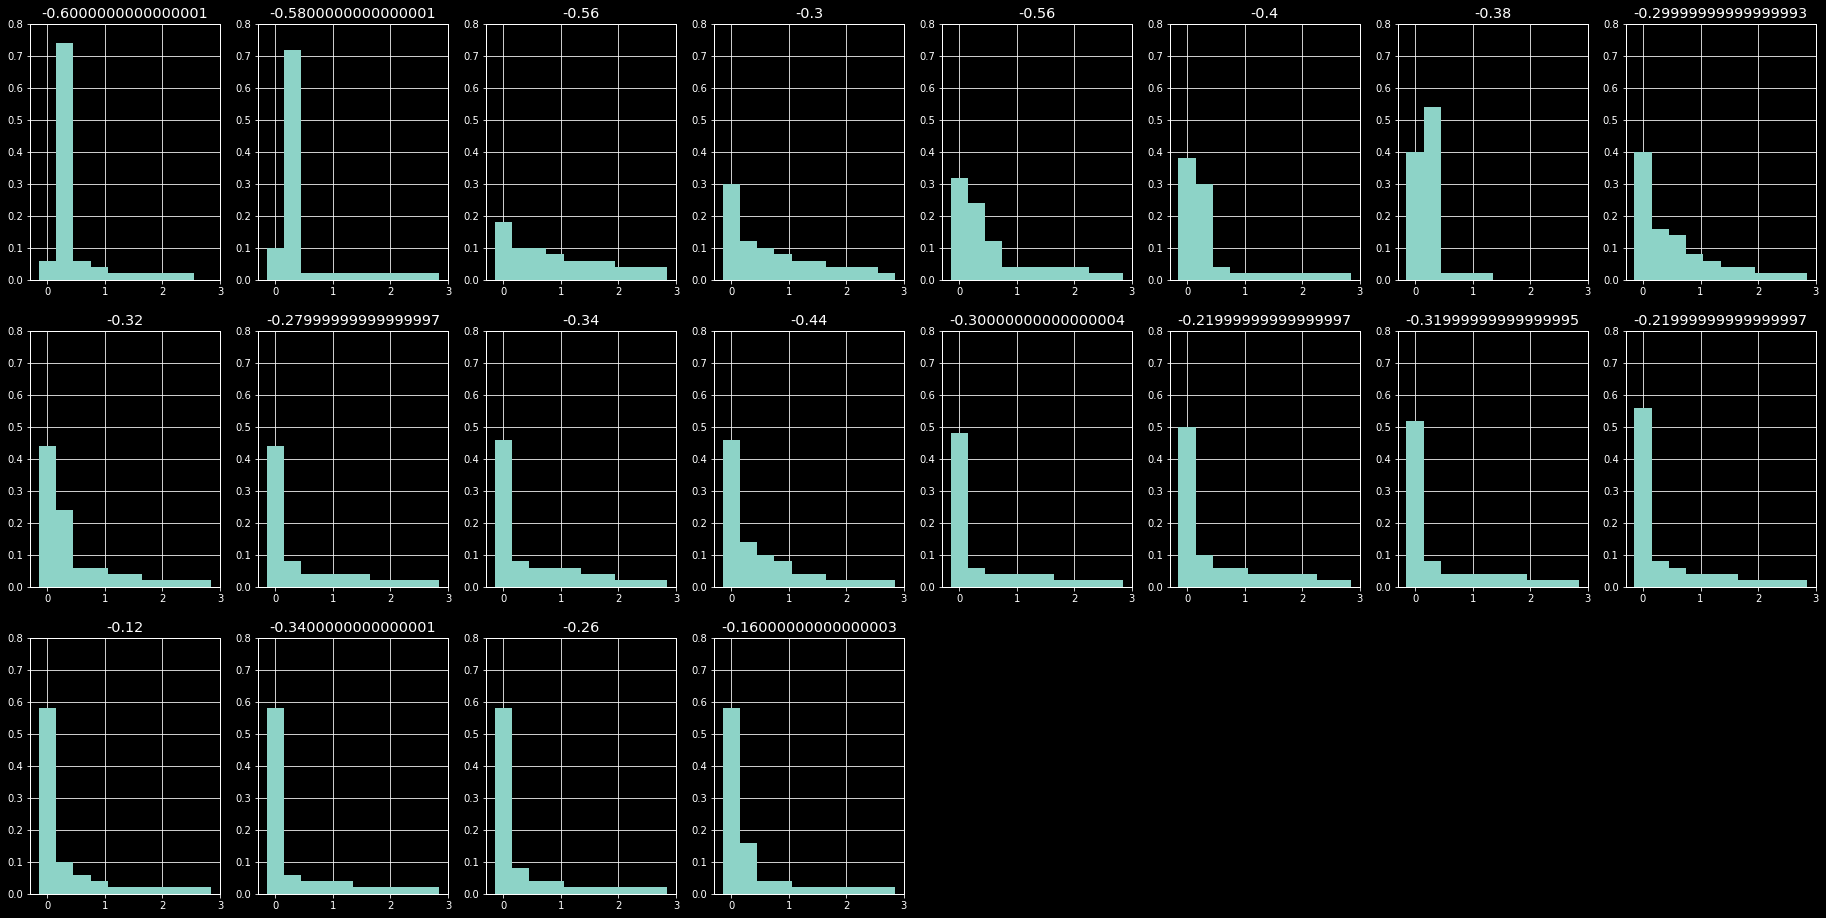

In [124]:
# selected_cls = list(range(5)) + list(range(10,15))
selected_cls = range(20)
err_mat = np.vstack(row_data)[:,1::2].astype(float)

cur_num_cols = int(8)
cur_num_rows = int(np.ceil(len(selected_cls) / cur_num_cols))
fig = plt.figure(figsize=(32,16))
for cur_idx, cur_cls in enumerate(selected_cls):
#     cur_nonzero = [i for i, err in enumerate(err_mat[cur_cls]) if float(err) > 0]
    cur_nonzero = np.arange(10)

    
    cur_ax = plt.subplot(cur_num_rows, cur_num_cols, int(cur_idx + 1))
    if True:# cur_idx < 5:
        cur_ax.set_ylim([0,0.8])
    cur_width = 0.3
    plt.bar(cur_nonzero*cur_width, err_mat[cur_cls][cur_nonzero], cur_width)
    cur_ax.set_title(str( err_mat[cur_cls][0] - corr_dict[idx2cls[str(sorted_idx[cur_idx])]]/50))
    

# fig.tight_layout()
plt.show()

In [44]:
err_mat[cur_cls][cur_nonzero]

array(['0.52', '0.08', '0.04', '0.04', '0.04', '0.04', '0.04', '0.02',
       '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02',
       '0.02'], dtype='<U9')

In [56]:
cur_nonzero

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [60]:
cur_num_rows

3

In [72]:
cur_ax.patches[0].get_width()

0.3

In [76]:
cur_ax.set

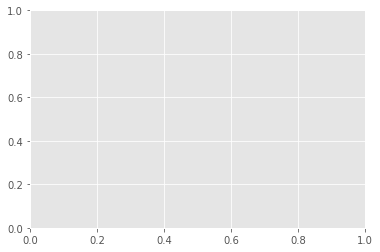

In [81]:
plt.gca()